# Variation with microbiome composition (Figure 3)

This script estimates the variation of FP excretion across different microbiome samples. To estimate this variation it takes abundance data from the curated metagenomics dataset from the Waldron lab (https://waldronlab.io/curatedMetagenomicData/index.html) and considers the relative abundance of the different experimentally characterized strains.

In [1]:
#load required packages
import pandas as pd
import subprocess
import numpy as np
import json
import os, sys
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import met_brewer
from datetime import datetime
import numpy as np
import json
import time
from matplotlib import rc_file
from pylab import *
import json

#read in basic characteristics of British reference diet
with open('data_analysisresults/BRD_characteristics.json', 'r') as fp:
        BRD = json.load(fp)

# variation of fp secretion with microbiome composition and health status
Disscussion Markus/Jonas after variation analysis, November 2023
- huge study to study variation but different groups within the same study (e.g. healthy vs IBD) show often very similar behavior with means often exactly matching
- no significant changes with age except for butyrate excretio which is clearly lower in infants (as expected)
- strong change in lactate vs propionate/succinate production when comparing Western vs non-Western samples (as defined in the curated metagenomics dataset)

Conclusion: 
- need in study comparisons and proper statistics.
- for RC's paper: remove iBD (or massiviely increase sample size and criticially evaluate). Possible nice point for change of butyrate/propionate with age by comparison with ourpredictions. Also, need to probe for possible trends WITHIN studies.

# Load measured yield data

In [2]:
#read information on experimentally characterized species
speciesinformation=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
characterized_species=speciesinformation["species"].tolist()

#print(df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
print(speciesinformation["species"])
#ll

#yieldresults (yields and excretion, here still in unites of mmol/OD l)
yieldresults=pd.read_csv("data_hplc/hplc_majorresults.csv")
#select data for which medium to use
yieldresults=yieldresults.loc[yieldresults["medium"]=="YCA"]

#merge yield information to species information
speciesinformation=speciesinformation.merge(yieldresults,left_on="species_HPLCname",right_on="species")
speciesinformation["species"] = speciesinformation['species_x']


display(speciesinformation.columns)
display(speciesinformation)

speciesinformation_taxonomiclevel=[]
taxlevels=["species","genus","family","order","class","phylum"]
taxlevels_names_characterized=[]
for taxlevel in taxlevels:
    speciesinformation_taxonomiclevel.append(speciesinformation.groupby(taxlevel).mean(numeric_only=True))
    display(speciesinformation_taxonomiclevel[-1])
    taxlevels_names_characterized.append(speciesinformation_taxonomiclevel[-1].index)


#plotting settings
sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate']
sublist_secretion=sublist[2:]
#sublist_color=['b','b','#1b9e77','#66a61e','#a6761d','#e7298a','#d95f02','#7570b3']
sublist_color = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
sublist_color=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']
sublist_color_secretion=sublist_color[2:]
sublist_energy=[0.68,1.36,0.21,0.52,0.,.33,0.37,0.36]
sublist_energy_secretion=sublist_energy[2:]

#conversion factor 
conversionfactorOD=0.5 #to go from mM/OD to mmol/g (1 OD l = 0.5 g)

average_uptake_secretion=pd.read_csv("data_analysisresults/secretion_microbiomestudies.csv",index_col=0)
display(average_uptake_secretion.head())

#information about samples from curated metagenomics data
colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")
colnames.rename(columns={'Unnamed: 0': 'sample'},inplace=True)
display(colnames.head(3))
display(colnames.shape)

0             Phocaeicola vulgatus
1             Bacteroides fragilis
2               Bacteroides ovatus
3     Bacteroides thetaiotaomicron
4                 Prevotella copri
5           Bacteroides finegoldii
6       Parabacteroides distasonis
7              Eubacterium rectale
8           Roseburia intestinalis
9     Faecalibacterium prausnitzii
10             Ruminococcus bromii
11          Bifidobacterium longum
12    Bifidobacterium adolescentis
13         Collinsella aerofaciens
14                Escherichia coli
15           Bacteroides uniformis
16                             NaN
17                             NaN
18                             NaN
19                             NaN
20                             NaN
21                             NaN
22                             NaN
23                             NaN
Name: species, dtype: object


Index(['species_HPLCname', 'species_x', 'new_species', 'species.1',
       'species_short', 'new_genus', 'genus', 'new_family', 'family',
       'new_order', 'order', 'new_class', 'class', 'new_phylum', 'phylum',
       'Unnamed: 0', 'species_y', 'glucose', 'acetate', 'propionate',
       'succinate', 'lactate', 'butyrate', 'formate', 'maltose', 'medium',
       'species'],
      dtype='object')

,species_HPLCname,species_x,new_species,species.1,species_short,new_genus,genus,new_family,family,new_order,...,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose,medium,species
0,B.vulgatus,Phocaeicola vulgatus,Phocaeicola vulgatus,Bacteroides vulgatus,B. vulgatus,Phocaeicola,Phocaeicola,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-5.365080,4.885603,0.627039,3.538685e+00,0.087761,0.000000,2.497726,0.000000,YCA,Phocaeicola vulgatus
1,B.fragilis,Bacteroides fragilis,Bacteroides fragilis,Bacteroides fragilis,B. fragilis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.832237,3.496001,0.380547,2.658095e+00,0.499204,0.000000,2.187005,0.000000,YCA,Bacteroides fragilis
2,B.ovatus,Bacteroides ovatus,Bacteroides ovatus,Bacteroides ovatus,B. ovatus,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.210851,8.802434,0.306027,1.523860e+00,0.307526,0.014638,10.289419,0.000000,YCA,Bacteroides ovatus
3,B.theta,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,B. theta,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-6.248500,4.504513,1.518513,2.332290e+00,0.728622,0.000000,0.925419,0.000000,YCA,Bacteroides thetaiotaomicron
4,P.copri,Prevotella copri,Prevotella copri,Prevotella copri,P. copri,Prevotella,Prevotella,Prevotellaceae,Prevotellaceae,Bacteroidales,...,-8.366688,4.894400,0.156131,2.300822e-16,12.054598,0.037772,5.919670,0.000000,YCA,Prevotella copri
5,B.finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,B. finegoldii,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,...,-4.654721,3.666919,0.999781,2.024829e+00,0.110719,0.014567,1.813101,0.000000,YCA,Bacteroides finegoldii
6,P.distastonis,Parabacteroides distasonis,Parabacteroides distasonis,Bacteroides distasonis,P. distastonis,Parabacteroides,Parabacteroides,Tannerellaceae,Tannerellaceae,Bacteroidales,...,-5.080898,2.790486,1.174451,2.204980e+00,0.188702,0.033736,1.513597,0.000000,YCA,Parabacteroides distasonis
7,E.rectale,Eubacterium rectale,Agathobacter rectalis,Eubacterium rectale,E. rectale,Agathobacter,Lachnospiraceae_NA,Lachnospiraceae,Lachnospiraceae,Eubacteriales,...,-6.572609,2.868648,0.729635,5.716495e-02,0.069866,3.887095,1.014707,0.000000,YCA,Eubacterium rectale
8,R.intestinalis,Roseburia intestinalis,Roseburia intestinalis,Roseburia intestinalis,R. intestinalis,Roseburia,Roseburia,Lachnospiraceae,Lachnospiraceae,Eubacteriales,...,-5.271650,3.204623,1.135440,1.358149e-01,0.003852,2.923401,1.280115,0.000000,YCA,Roseburia intestinalis
9,F.prausnitzii,Faecalibacterium prausnitzii,Faecalibacterium prausnitzii,Faecalibacterium prausnitzii,F. prausnitzii,Faecalibacterium,Faecalibacterium,Oscillospiraceae,Oscillospiraceae,Eubacteriales,...,0.000000,0.050004,0.695780,5.799652e-02,0.000000,4.366987,6.256170,-2.670849,YCA,Faecalibacterium prausnitzii


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
species,,,,,,,,,
Bacteroides finegoldii,154.0,-4.654721,3.666919,0.999781,2.024829e+00,0.110719,0.014567,1.813101,0.000000
Bacteroides fragilis,156.0,-4.832237,3.496001,0.380547,2.658095e+00,0.499204,0.000000,2.187005,0.000000
Bacteroides ovatus,163.0,-4.210851,8.802434,0.306027,1.523860e+00,0.307526,0.014638,10.289419,0.000000
Bacteroides thetaiotaomicron,166.0,-6.248500,4.504513,1.518513,2.332290e+00,0.728622,0.000000,0.925419,0.000000
Bacteroides uniformis,170.0,-6.650701,3.610049,0.292439,3.280870e-16,10.845330,0.009401,4.765271,0.000000
Bifidobacterium adolescentis,152.0,-8.238885,12.114113,2.233406,5.445836e-01,3.221920,0.000000,0.998964,0.000000
Bifidobacterium longum,160.0,-9.243031,13.612177,1.578880,4.546007e-01,3.149715,0.000000,1.157540,0.000000
Collinsella aerofaciens,174.0,-6.349981,4.440344,1.756295,2.722113e-01,2.050443,0.387110,5.122145,0.000000
Escherichia coli,177.0,-3.814797,9.180978,0.045235,1.626422e+00,0.404698,0.055980,10.117315,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
genus,,,,,,,,,
Bacteroides,161.8,-5.319402,4.815983,0.699462,1.707815e+00,2.498280,0.007721,3.996043,0.000000
Bifidobacterium,156.0,-8.740958,12.863145,1.906143,4.995921e-01,3.185817,0.000000,1.078252,0.000000
Collinsella,174.0,-6.349981,4.440344,1.756295,2.722113e-01,2.050443,0.387110,5.122145,0.000000
Escherichia,177.0,-3.814797,9.180978,0.045235,1.626422e+00,0.404698,0.055980,10.117315,0.000000
Faecalibacterium,184.0,0.000000,0.050004,0.695780,5.799652e-02,0.000000,4.366987,6.256170,-2.670849
Lachnospiraceae_NA,181.0,-6.572609,2.868648,0.729635,5.716495e-02,0.069866,3.887095,1.014707,0.000000
Parabacteroides,188.0,-5.080898,2.790486,1.174451,2.204980e+00,0.188702,0.033736,1.513597,0.000000
Phocaeicola,171.0,-5.365080,4.885603,0.627039,3.538685e+00,0.087761,0.000000,2.497726,0.000000
Prevotella,187.0,-8.366688,4.894400,0.156131,2.300822e-16,12.054598,0.037772,5.919670,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
family,,,,,,,,,
Bacteroidaceae,163.333333,-5.327015,4.827586,0.687391,2.012960e+00,2.096527,0.006434,3.746324,0.00000
Bifidobacteriaceae,156.000000,-8.740958,12.863145,1.906143,4.995921e-01,3.185817,0.000000,1.078252,0.00000
Coriobacteriaceae,174.000000,-6.349981,4.440344,1.756295,2.722113e-01,2.050443,0.387110,5.122145,0.00000
Enterobacteriaceae,177.000000,-3.814797,9.180978,0.045235,1.626422e+00,0.404698,0.055980,10.117315,0.00000
Lachnospiraceae,186.500000,-5.922130,3.036636,0.932537,9.648995e-02,0.036859,3.405248,1.147411,0.00000
Oscillospiraceae,187.000000,0.000000,3.853708,1.805810,6.320450e-02,1.980546,2.360721,4.845451,-2.09861
Prevotellaceae,187.000000,-8.366688,4.894400,0.156131,2.300822e-16,12.054598,0.037772,5.919670,0.00000
Tannerellaceae,188.000000,-5.080898,2.790486,1.174451,2.204980e+00,0.188702,0.033736,1.513597,0.00000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
order,,,,,,,,,
Bacteroidales,169.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Bifidobacteriales,156.000,-8.740958,12.863145,1.906143,0.499592,3.185817,0.000000,1.078252,0.000000
Coriobacteriales,174.000,-6.349981,4.440344,1.756295,0.272211,2.050443,0.387110,5.122145,0.000000
Enterobacterales,177.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000
Eubacteriales,186.750,-2.961065,3.445172,1.369174,0.079847,1.008703,2.882984,2.996431,-1.049305


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
class,,,,,,,,,
Actinomycetia,156.000,-8.740958,12.863145,1.906143,0.499592,3.185817,0.000000,1.078252,0.000000
Bacteroidia,169.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Clostridia,186.750,-2.961065,3.445172,1.369174,0.079847,1.008703,2.882984,2.996431,-1.049305
Coriobacteriia,174.000,-6.349981,4.440344,1.756295,0.272211,2.050443,0.387110,5.122145,0.000000
Gammaproteobacteria,177.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000


,Unnamed: 0,glucose,acetate,propionate,succinate,lactate,butyrate,formate,maltose
phylum,,,,,,,,,
Actinobacteria,162.000,-7.943966,10.055545,1.856194,0.423799,2.807359,0.129037,2.426216,0.000000
Bacteroidetes,169.375,-5.676209,4.581301,0.681866,1.785342,3.102808,0.013764,3.738901,0.000000
Firmicutes,186.750,-2.961065,3.445172,1.369174,0.079847,1.008703,2.882984,2.996431,-1.049305
Proteobacteria,177.000,-3.814797,9.180978,0.045235,1.626422,0.404698,0.055980,10.117315,0.000000


,glucose,maltose,acetate,butyrate,formate,lactate,propionate,succinate,BM_represented,uptake,...,phylumlevel_butyrate,phylumlevel_formate,phylumlevel_lactate,phylumlevel_propionate,phylumlevel_succinate,phylumlevel_BM_represented,phylumlevel_uptake,phylumlevel_total_secretion,phylumlevel_total_secretion_energy,phylumlevel_dryweightBRD
MV_FEI1_t1Q14,-8.889497,0.0,19.390446,0.098968,18.155049,1.446519,0.446432,2.980862,67.14199,8.889497,...,0.930423,14.380525,2.190178,1.371364,2.217724,99.94684,10.059766,38.308269,6.128156,19.682807
N2_064_025G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.55503,7.629594,...,2.467144,13.871977,1.449395,1.295271,1.897757,99.70264,8.901503,34.623604,5.788491,22.243934
N2_064_020G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.08161,7.629594,...,2.153824,15.017118,1.269278,1.064299,2.124290,99.64744,8.569285,35.858081,5.685532,23.106297
N2_064_017G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,...,3.250905,12.328005,1.480048,1.560496,1.535615,99.95467,9.011836,32.148313,5.827673,21.971599
N2_064_016G1,-7.629594,0.0,18.361956,0.111961,20.234629,0.809396,0.090470,3.252844,0.11707,7.629594,...,2.315183,14.684978,1.280126,1.122280,2.047523,99.92075,8.599788,35.341853,5.695959,23.024340


/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_1910/180563817.py:48: DtypeWarning: Columns (21,22,27,29,30,33,36,43,50,52,53,54,55,56,57,62,63,70,72,76,77,87,90,98,99,102,106,107,108,109,111,114,115,116,123) have mixed types. Specify dtype option on import or set low_memory=False.
  colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")


,sample,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
0,MV_FEI1_t1Q14,AsnicarF_2017,MV_FEI1,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MV_FEI2_t1Q14,AsnicarF_2017,MV_FEI2,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MV_FEI3_t1Q14,AsnicarF_2017,MV_FEI3,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18725, 130)

In [3]:
#look at specific studies and disease state

#display(colnames['disease'].unique())
#display(colnames['study_name'].unique())

#IBD
#studyc="HallAB_2017"
#studyc="HMP_2019_ibdmdb"
#studyc="IjazUZ_2017"
#studyc="NielsenHB_2014"
#studyc="VilaAV_2018" #only IBD study
#studyc="LiJ_2014"


#CRC
studyc='FengQ_2015' #a lot of different disease details
#studyc='GuptaA_2019' #'CRC', 'healthy'
#studyc='HanniganGD_2017' #['adenoma', 'healthy', 'CRC'
#studyc='ThomasAM_2018a' #a lot of different details
#studyc='ThomasAM_2018b' #'CRC', 'healthy'
#studyc='ThomasAM_2019_c' #'healthy', 'CRC'
#studyc='VogtmannE_2016' #'healthy', 'CRC'
#studyc='WirbelJ_2018' #'CRC', 'healthy'
#studyc='YachidaS_2019' #'CRC', 'healthy', 'carcinoma_surgery_history', 'adenoma', 'few_polyps'
#studyc='YuJ_2015' #'CRC;T2D', 'CRC', 'healthy', 'T2D'
#studyc='ZellerG_2014' #'healthy', 'CRC', 'adenoma'

colnames.loc[colnames['study_name']==studyc]["disease"].unique()
#find all studies with entry IBD
#colnames.loc[colnames['disease']=="CRC"]["study_name"].unique()

#list of IBD studies

array(['CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'healthy', 'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver'],
      dtype=object)

array(['newborn', 'child', 'adult', 'schoolage', 'senior'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['healthy', 'premature_born', 'RA',
       'gestational_diabetes;pre-eclampsia', 'gestational_diabetes',
       'chorioamnionitis', 'pre-eclampsia', 'acute_diarrhoea',
       'CRC;fatty_liver;hypertension', 'fatty_liver;hypertension',
       'adenoma;fatty_liver;hypertension', 'fatty_liver',
       'T2D;fatty_liver;hypertension', 'adenoma;fatty_liver', 'CRC',
       'hypertension', 'adenoma', 'CRC;T2D;fatty_liver;hypertension',
       'CRC;hypertension', 'T2D;hypertension', 'T2D;adenoma',
       'T2D;adenoma;hypertension', 'adenoma;hypertension',
       'CRC;fatty_liver', 'CRC;T2D;hypertension', 'T2D;fatty_liver',
       'T2D;adenoma;fatty_liver;hypertension', 'T2D;adenoma;fatty_liver',
       'melanoma;metastases', 'IBD', 'T1D',
       'CMV;coeliac;gestational_diabetes', 'T1D;coeliac;irritable_bowel',
       'hepatitis', 'IGT', 'IGT;respiratoryinf', 'respiratoryinf', 'T2D',
       'T2D;respiratoryinf', 'ACVD', 'IBD;perianal_fistula',
       'metabolic_syndrome', 'STEC', 'cirrhos

HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_All_NW_All
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
HMP_2019_ibdmdb
healthy
(426, 130)
HMP_2019_ibdmdb_disease_healthy_age_All_NW_All
[[0, 25, 50, 75, 100], [0, 250, 500, 750, 1000], [0, 10, 20, 30], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300], [0, 100, 200, 300]]
['BM_represented', 'total_secretion', 'dryweightBRD', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']


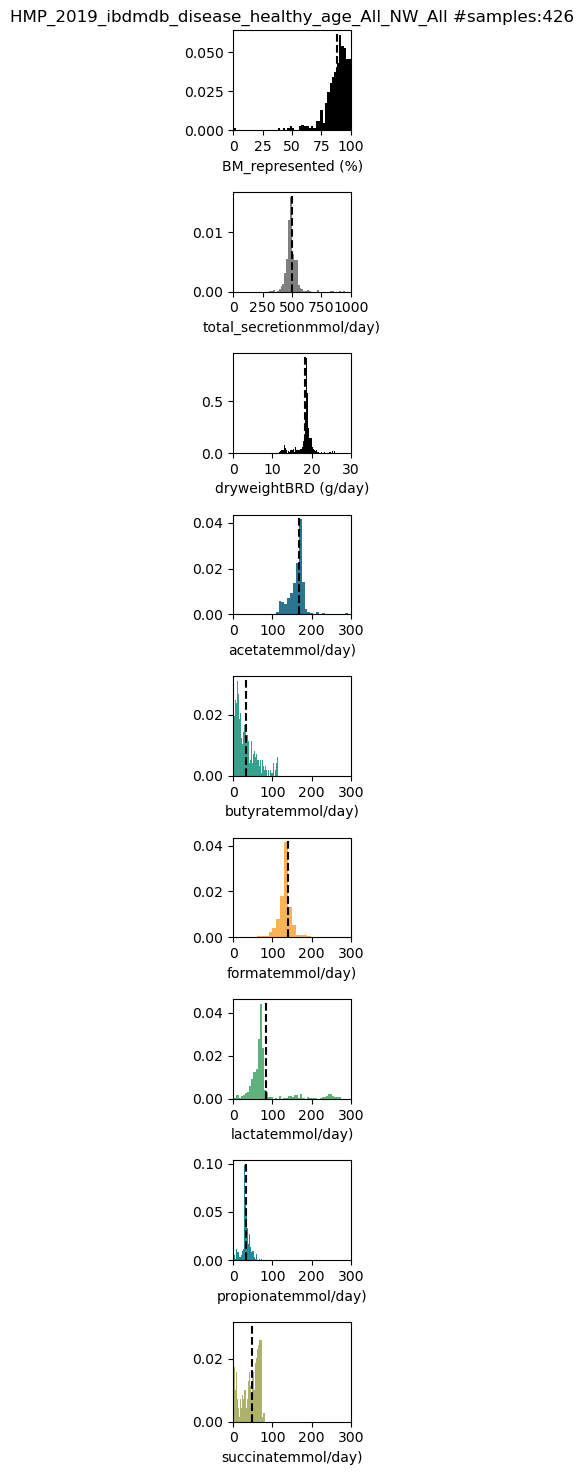

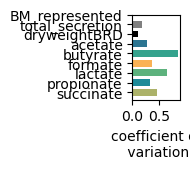

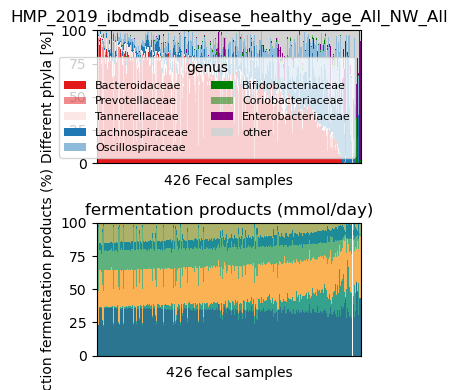

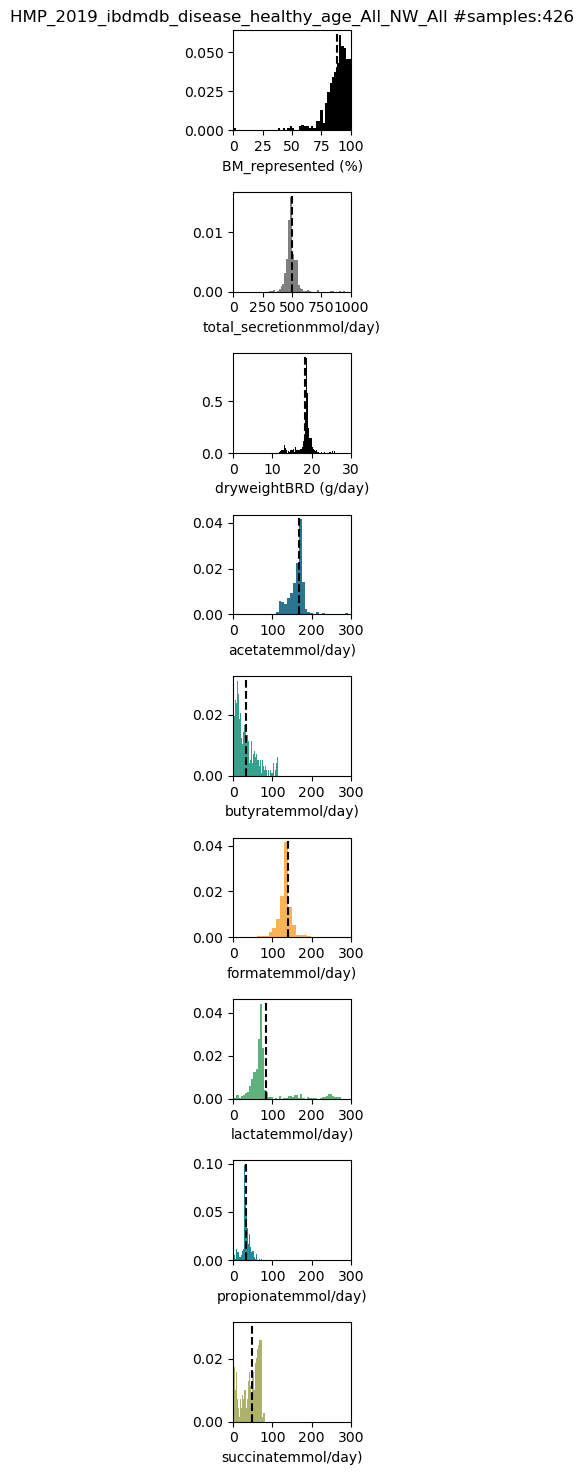

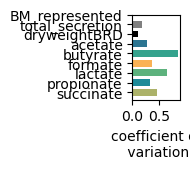

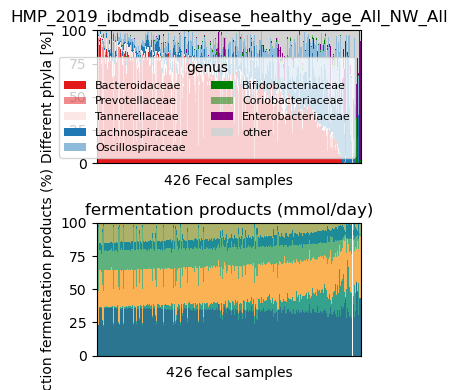

In [18]:
# Select different samples and plot distributions
taxlevelselect="family"

display(colnames['age_category'].unique())
display(colnames['non_westernized'].unique())
display(colnames['disease'].unique())

study_name_l=["All"]
disease_l=["All"] #if  None, all health properties will be included
age_category_l=["All"]*len(study_name_l)
non_westernized_l=["All"]*len(study_name_l)

#different IBD studies
#study_name_l=["HallAB_2017","HallAB_2017","HMP_2019_ibdmdb","HMP_2019_ibdmdb","IjazUZ_2017","IjazUZ_2017","NielsenHB_2014","NielsenHB_2014","LiJ_2014","LiJ_2014","VilaAV_2018"]
#disease_l=["healthy","IBD"]*5+["IBD"] #if  None, all health properties will be included
#age_category_l=["All"]*len(study_name_l)
#non_westernized_l=["All"]*len(study_name_l)

#western vs non-wester
#study_name_l=["All"]*2
#disease_l=["All"]*len(study_name_l)#if  None, all health properties will be included
#age_category_l=["All"]*len(study_name_l)
#non_westernized_l=["yes","no"]

#different IBD studies
study_name_l=["HMP_2019_ibdmdb","HMP_2019_ibdmdb"]
disease_l=["healthy","healthy"]
age_category_l=["All"]*len(study_name_l)
non_westernized_l=["All"]*len(study_name_l)

#crc
#study_name_l=["GuptaA_2019","GuptaA_2019","HanniganGD_2017","HanniganGD_2017","ThomasAM_2018b","ThomasAM_2018b","ThomasAM_2019_c","ThomasAM_2019_c","VogtmannE_2016","VogtmannE_2016","WirbelJ_2018","WirbelJ_2018"]
#study_name_l=study_name_l+["YachidaS_2019","YachidaS_2019","YuJ_2015","YuJ_2015","ZellerG_2014","ZellerG_2014"]
#disease_l=["healthy","CRC"]*int(len(study_name_l)/2) #if  None, all health properties will be included
#age_category_l=["All"]*len(study_name_l)
#non_westernized_l=["All"]*len(study_name_l)

results=[]
results_taxlevel=[]
name_conditionlist=[]
studycountc=-1
for study_name in study_name_l:
    print(study_name)
    studycountc=studycountc+1
    #select samples belonging to specific study / metadata
    select=colnames.loc[(colnames['body_site']=='stool')]
    if  study_name=="All":
                        pass
    else:
        select=select.loc[select["study_name"]==study_name]            
    #health condition
    disease=disease_l[studycountc]
    if disease=="All":
            pass
    else:
        print(disease)
        select=select.loc[select["disease"]==disease]
        print(select.shape)
    age_category=age_category_l[studycountc]
    if age_category=="All":
            pass
    else:
        select=select.loc[select["age_category"]==age_category]
    
    non_westernized=non_westernized_l[studycountc]
    if non_westernized=="All":
            pass
    else:
        select=select.loc[select["non_westernized"]==non_westernized]
            
    #add additional selection conditions here
    #antibiotics_current_use
    #study_condition
    #disease
    #age
    #infant_age
    #age_category newborn', 'child', 'adult', 'schoolage', 'senior
    #gender
    #country
    #non_westernized no,yes
    #pregnant 
    #lactating
    #BMI
    
    #....there are a lot more characteristics mentioned in the metadata table
    if select.shape[0]==0:
        print("error: no samples found")
        error

    conditionname=study_name+"_disease_"+disease+"_age_"+age_category+"_NW_"+non_westernized
    #conditionname=conditionname.replace("/","_")
    print(conditionname)
    name_conditionlist.append(conditionname)
    results.append([])
    results_taxlevel.append([])
    ##### no go through different plots
    
    select_samples=select["sample"].tolist()
    number_samples=len(select_samples)
    
    #select data and sort (for phyla distribution plots)
    select_data=average_uptake_secretion.loc[select_samples]#.dropna(how="any")
    select_data.sort_values(by=['phylumlevel_Bacteroidetes'],inplace=True,ascending=False)

    #### save average as JSON file
    #average to dict
    
    dict_out=select_data.mean(axis=0).to_dict()
    with open("data_analysisresults/average_excretion/selectedsamples_"+conditionname+".json", 'w') as fp:
        json.dump(dict_out, fp)

    
    quantities_to_plot=["BM_represented","total_secretion","dryweightBRD"]+sublist_secretion
    colorlistcc=["k","gray","k"]+sublist_color_secretion
    
    #set labels for quantities
    labellist=[]
    for Q in quantities_to_plot:
        if Q in ["BM_represented"]:
            labellist.append(Q+" (%)")
        elif Q in ["dryweightBRD"]:
            labellist.append(Q+" (g/day)")
        else:
            labellist.append(Q+"mmol/day)")    
    #set limits for quantities
    limmaxlist=[100,1000,30]+[300]*len(sublist_secretion)
    tickslist=[[0,25,50,75,100],[0,250,500,750,1000],[0,10,20,30]]+[[0,100,200,300]]*6
    
    print(tickslist)
    
    ###########
    #plot distributions of all fermentation products (and total secretion and weight)
    ###########

    fig, ax=plt.subplots(len(quantities_to_plot),figsize=(2,3*3.3)) #first column y, second colum x
    ax[0].set_title(conditionname+" #samples:"+str(number_samples))
    
    distributionprob=pd.DataFrame()
    
    sc=-1
    for sub in quantities_to_plot:
        sc=sc+1
        taxleveldata=None
        curdata_taxlevel=[]
        if sub in ["dryweightBRD"]: 
            taxleveldata=True
            #curdata=select_data[sub]
            
            for taxlevel in taxlevels:
                curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
        elif sub in  ["BM_represented"]: 
            #curdata=select_data[sub]
            taxleveldata=True
            for taxlevel in taxlevels:
                curdata_taxlevel.append(select_data[taxlevel+"level_"+sub])
        else:
            #curdata=select_data[sub]*select_data["dryweightBRD"]
            taxleveldata=True
            for taxlevel in taxlevels:
                curdata_taxlevel.append(select_data[taxlevel+"level_"+sub]*select_data[taxlevel+"level_dryweightBRD"])
        
        #results[studycountc].append(curdata)
        if taxleveldata:
            results_taxlevel[studycountc].append(curdata_taxlevel)
        else:
            results_taxlevel[studycountc].append([[] for _ in range(len(taxlevels))])
        
        #print(sub)
        #print(select_data[sub].mean())
        #print(select_data["dryweightBRD"].mean())
        distributionprob.at[sub,"mean"]=curdata_taxlevel[taxlevels.index(taxlevelselect)].mean()
        distributionprob.at[sub,"std"]=curdata_taxlevel[taxlevels.index(taxlevelselect)].std()
        distributionprob.at[sub,"CV"]=distributionprob.at[sub,"std"]/distributionprob.at[sub,"mean"]

        
        ax[sc].set_xlim(0,limmaxlist[sc])
            #ax[sc].set_xlim(0,700)
        if sub in ["dryweightBRD","BM_represented"]:
            bins=30
        else:
            bins=np.linspace(0,450,30)
        ax[sc].hist(curdata_taxlevel[taxlevels.index(taxlevelselect)],color=colorlistcc[sc],alpha=1,density=True,bins=50)
        ax[sc].axvline(distributionprob.at[sub,"mean"],ls='--',c='k')
        
        ax[sc].set_xlabel(labellist[sc])
        ax[sc].set_xticks(tickslist[sc])
        
        #ax[sc].text(0.72,0.8,"CV="+str(round(distributionprob.at[sub,"CV"],2)),c='k',transform=ax[sc].transAxes)
       

    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+"_"+taxlevelselect+"level.pdf")

    fig.set_size_inches(2.15,4.5*3.3)
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+"_"+taxlevelselect+"level_bigger.pdf")

    ###########
    #plot coefficient of variation and boxplots showing variation of secretion
    ###########
    colorlistcc2=sublist_color_secretion[::-1]+["gray"]
    fig2,ax2=plt.subplots(1,1,figsize=(2.0,1.8))
    sc=-1
    list_box=[]
    colorlistcc2=[]
    
    ax2.set_xlabel("coefficient of\n variation")
    print(quantities_to_plot)
    for sub in quantities_to_plot[1:][::-1]:
        sc=sc+1
        ax2.barh(sc+1,distributionprob.at[sub,"CV"],color=colorlistcc[::-1][sc],height=0.7)
    ax2.set_yticks(range(1,len(quantities_to_plot)+1))
    ax2.set_yticklabels(quantities_to_plot[::-1])
    fig2.tight_layout()
    fig2.savefig("plot_output_figure3/barout"+conditionname+"_"+taxlevelselect+"level.pdf")

    
    if number_samples>5000:
        print("no pyla plots for more than 5000 samples")
    else:
        ###########################
        #### plot phyla abundance
        ###########################
        fig3, ax3=plt.subplots(2,1,figsize=(3.5,(2)*2)) #first column y, second colum x

        ax3[0].set_xlabel(str(number_samples)+" Fecal samples")
        ax3[0].set_ylabel("Different phyla [%]")
        ax3[0].set_ylim(0,100)
        ax3[0].set_xlim(0,number_samples)
        ax3[0].set_xticks([])
        ax3[0].set_title(conditionname)
        samplecount=-1
        
        familys=["Bacteroidaceae","Prevotellaceae","Tannerellaceae","Lachnospiraceae","Oscillospiraceae","Bifidobacteriaceae","Coriobacteriaceae","Enterobacteriaceae"]
        #genusl=["Phocaeicola","Bacteroides","Prevotella","Parabacteroides"]
        #colors_phyla=['#e31a1c']*4
        #alphal=[1,0.76,0.5,0.3]
        #genusl=genusl+["Lachnospiraceae_NA","Roseburia","Faecalibacterium","Ruminococcus"]
        #colors_phyla=colors_phyla+["#1f78b4"]*4
        
        #alphal=alphal+[1,0.76,0.5,0.3]
        #genusl=genusl+["Bifidobacterium","Collinsella","Escherichia"]
        #colors_phyla=colors_phyla+["#4daf4a"]*2
        #colors_phyla=colors_phyla+["#984ea3"]
        #alphal=alphal+[1,0.5,1]
        
        alphal=[1,0.5,0.1,1,0.5,1,0.5,1]
        colors_phyla=['#e31a1c','#e31a1c','#e31a1c','#1f78b4','#1f78b4','green','green','purple']
        #changed color slightly to be able to change it via illustrator later if wanted
        #colors_phyla=['#e31a1c','#e31a1d','#e31a1e','#1f78b4','#1f78b5','#ffb600','#ffb601','#33a02c']
        #colors_phyla=['#e41a1c','#e41a1d','#e41a1e','#377eb8','#377eb9','#4daf4a','#4daf4a','#984ea3']#,'#ff7f00']
        
        for sample in select_data.index:
            samplecount=samplecount+1
            bar_width = 1
            y_offset = 0
            #colors_phyla=['#e31a1c','#1f78b4','#b2df8a','#33a02c','#fb9a99','#a6cee3','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
            pc=-1
            
            for p in familys: #genusl: #['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria']:
                
                if samplecount==0:
                    labelc=p
                else:
                    labelc=None
                pc=pc+1
                #display(select_data.columns)
                #print(p)
                #p_ab=select_data.at[sample,"phylumlevel_"+p]
                p_ab=select_data.at[sample,"familylevel_"+p]
                
            
                #phyla_abundance[samplecount,pc]=p_ab
                ax3[0].bar(samplecount, p_ab, bar_width, bottom=y_offset,alpha=alphal[pc], color=colors_phyla[pc],edgecolor = "none",label=labelc)
                y_offset = y_offset + p_ab
            #add color for other fila
            if samplecount==2:
                ax3[0].bar(samplecount, 100-p_ab,bar_width, bottom=y_offset,alpha=alphal[pc], color="lightgray",edgecolor = "none",label="other")
            else:
                ax3[0].bar(samplecount, 100-p_ab,bar_width, bottom=y_offset,alpha=alphal[pc], color="lightgray",edgecolor = "none")
        ax3[0].legend(title="genus",ncol=2,fontsize=8)
           
        ###########################
        #### plot secretion
        ###########################    
        ax3[1].set_xlabel(str(number_samples)+" fecal samples")
        ax3[1].set_ylabel("fraction fermentation products (%)")
        ax3[1].set_ylim(0,100)
        ax3[1].set_xlim(0,number_samples)
        ax3[1].set_xticks([])
        ax3[1].set_title("fermentation products (mmol/day)")
        
        samplecount=-1
        for sample in select_data.index:
            samplecount=samplecount+1
            bar_width = 1
            y_offset = 0

            normalization=0
            sc=-1
            for sub in sublist_secretion:
                sc=sc+1
                normalization=normalization+select_data.at[sample,taxlevelselect+"level_"+sub]/100.

            sc=-1
            for sub in sublist_secretion:
                sc=sc+1
                if samplecount==0:
                    labelc=sub
                else:
                    labelc=None

                cursec=select_data.at[sample,taxlevelselect+"level_"+sub]/normalization
                ax3[1].bar(samplecount, cursec, bar_width, bottom=y_offset, color=sublist_color_secretion[sc],edgecolor = "none",label=labelc)
                y_offset = y_offset + cursec
        
        fig3.tight_layout()
        fig3.savefig("plot_output_figure3/phylavariation"+conditionname+"_"+taxlevelselect+"level.pdf")




# Plot variation across different studies

Only use this for more than one study/condition comparison

shown taxonomic level: family
#acb269
BM_represented
total_secretion
dryweightBRD
acetate
butyrate
formate
lactate
propionate
succinate


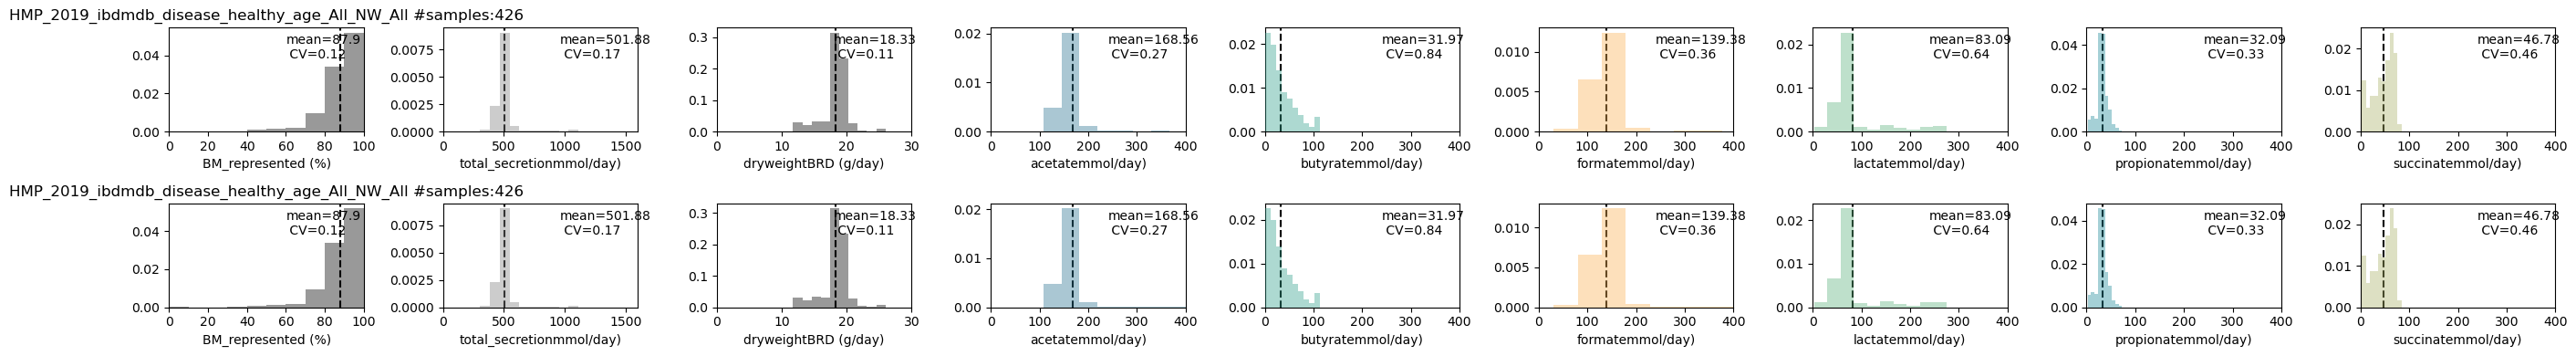

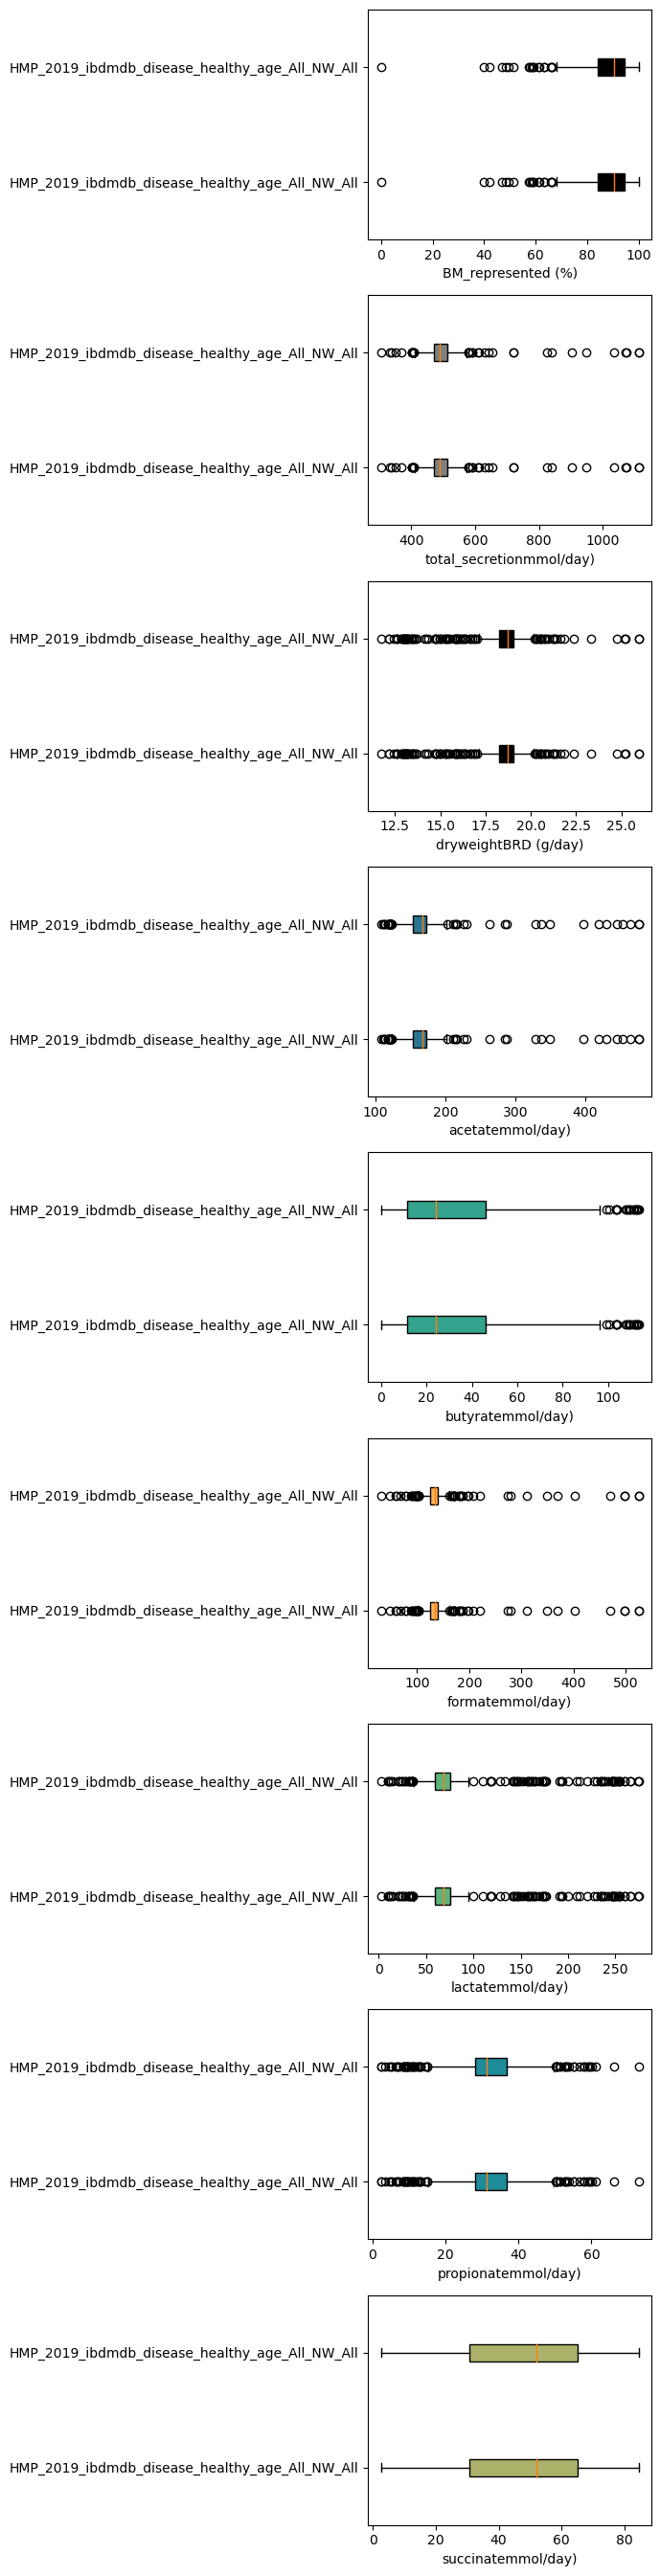

In [6]:

taxlevel_select='family'#'genus', 'family', 'order', 'class', 'phylum']
taxlevel_select_index=taxlevels.index(taxlevel_select)
print("shown taxonomic level: "+taxlevel_select)

fig, ax=plt.subplots(len(name_conditionlist),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(name_conditionlist))) #first column y, second colum x

boxplotdata=[]

iC = -1
for condition in name_conditionlist:
    iC=iC+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        if iC==0:
            boxplotdata.append([])
            
        #curdata=results[iC][pQ]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        if len(curdata_phylalevel)==0:
            plottaxonomiclevel=False
        else:
            plottaxonomiclevel=True
        
        
        mean=curdata_phylalevel.mean()
        std=curdata_phylalevel.std()
        cv=std/mean

        if pQ==0:
            ax[iC,pQ].set_title(condition+" #samples:"+str(curdata_phylalevel.shape[0]))
            colorlistcc
    
        
        
        ax[iC,pQ].text(0.6,0.7,"mean="+str(round(mean,2))+"\n CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)
        
        if plottaxonomiclevel:
            ax[iC,pQ].hist(curdata_phylalevel,color=colorlistcc[pQ],alpha=0.4,density=True,zorder=4)
        else:
            error
        boxplotdata[pQ].append(curdata_phylalevel.dropna().values) #remove also nan to ensure box plot works
        ax[iC,pQ].axvline(mean,ls='--',c='k')
        ax[iC,pQ].set_xlabel(labellist[pQ])
        ax[iC,pQ].set_xlim(0,limmaxlist[pQ])
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")


#plot boxplot
fig2, ax2=plt.subplots(len(quantities_to_plot),1,figsize=(7,3*len(quantities_to_plot))) #first column y, second colum x

print(colorlistcc[pQ])
pQ = -1
for plot_quantity in quantities_to_plot:
    print(plot_quantity)
    pQ=pQ+1
    bplc=ax2[pQ].boxplot(boxplotdata[pQ],patch_artist=True,vert=False) #showfliers=False
    ax2[pQ].set_xlabel(labellist[pQ])
    #ax2[0].boxplot(list_box,patch_artist=True,vert=False,)#,"Mice (autoclaved lab coy)"])
    for patch in bplc['boxes']:
        patch.set_facecolor(colorlistcc[pQ])
    
    #labels
    ax2[pQ].set_yticks(range(1,len(name_conditionlist)+1))
    ax2[pQ].set_yticklabels(name_conditionlist)
    
fig2.tight_layout()
fig2.savefig("plot_output_figure3/distribution_microbiomesamples_boxplots_"+conditionname+".pdf")


# Plot cross correlation phyla level vs species level

shown taxonomic level: class


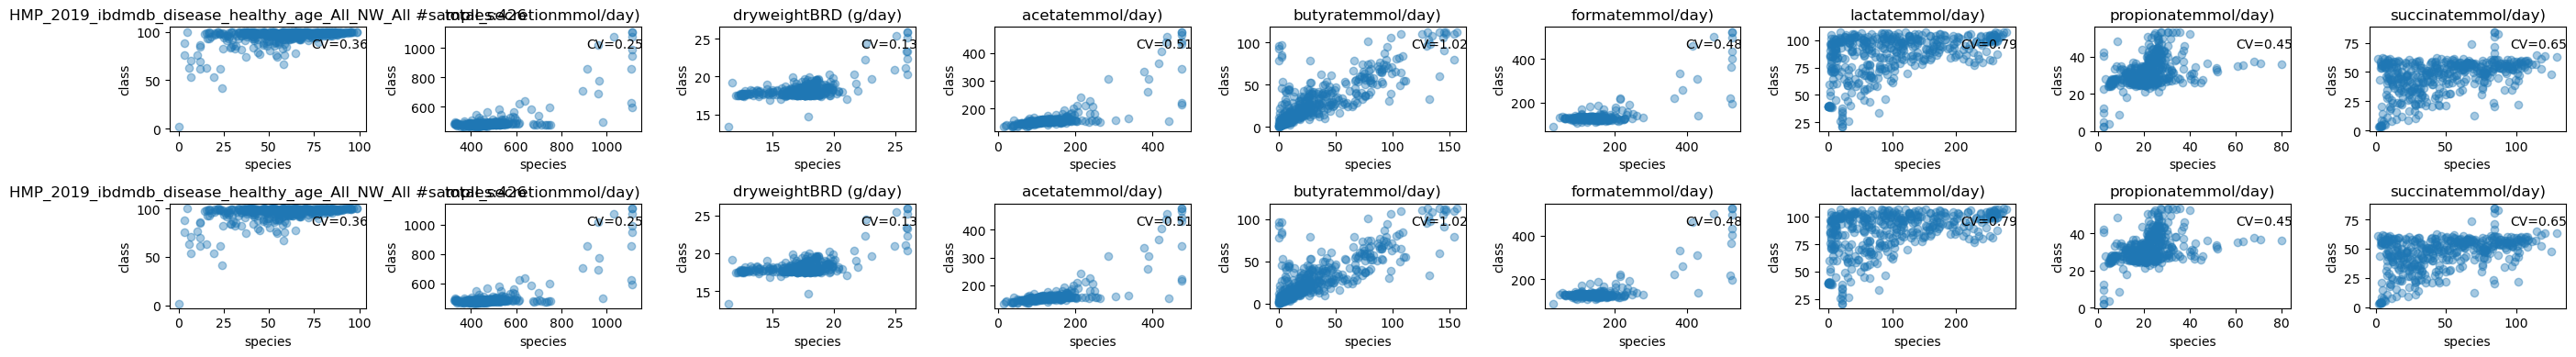

In [7]:
taxlevel_select='class'#'genus', 'family', 'order', 'class', 'phylum']
taxlevel_select_index=taxlevels.index(taxlevel_select)
print("shown taxonomic level: "+taxlevel_select)

fig, ax=plt.subplots(len(name_conditionlist),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(name_conditionlist))) #first column y, second colum x
iC = -1
for condition in name_conditionlist:
    iC=iC+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        curdata=results_taxlevel[iC][pQ][taxlevels.index("species")]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        
        mean=curdata.mean()
        std=curdata.std()
        cv=std/mean

        if pQ==0:
            ax[iC,pQ].set_title(condition+" #samples:"+str(curdata.shape[0]))
            colorlistcc
        ax[iC,pQ].text(0.72,0.8,"CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)

        try:
            ax[iC,pQ].scatter(curdata,curdata_phylalevel,alpha=0.4)
        except:
            pass
        ax[iC,pQ].set_ylabel(taxlevel_select)
        ax[iC,pQ].set_xlabel("species")
        
        if pQ != 0:
            ax[iC,pQ].set_title(labellist[pQ])
            
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")


    
    

# Plot for one condition different taxonomic levels

/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_1910/3939361629.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


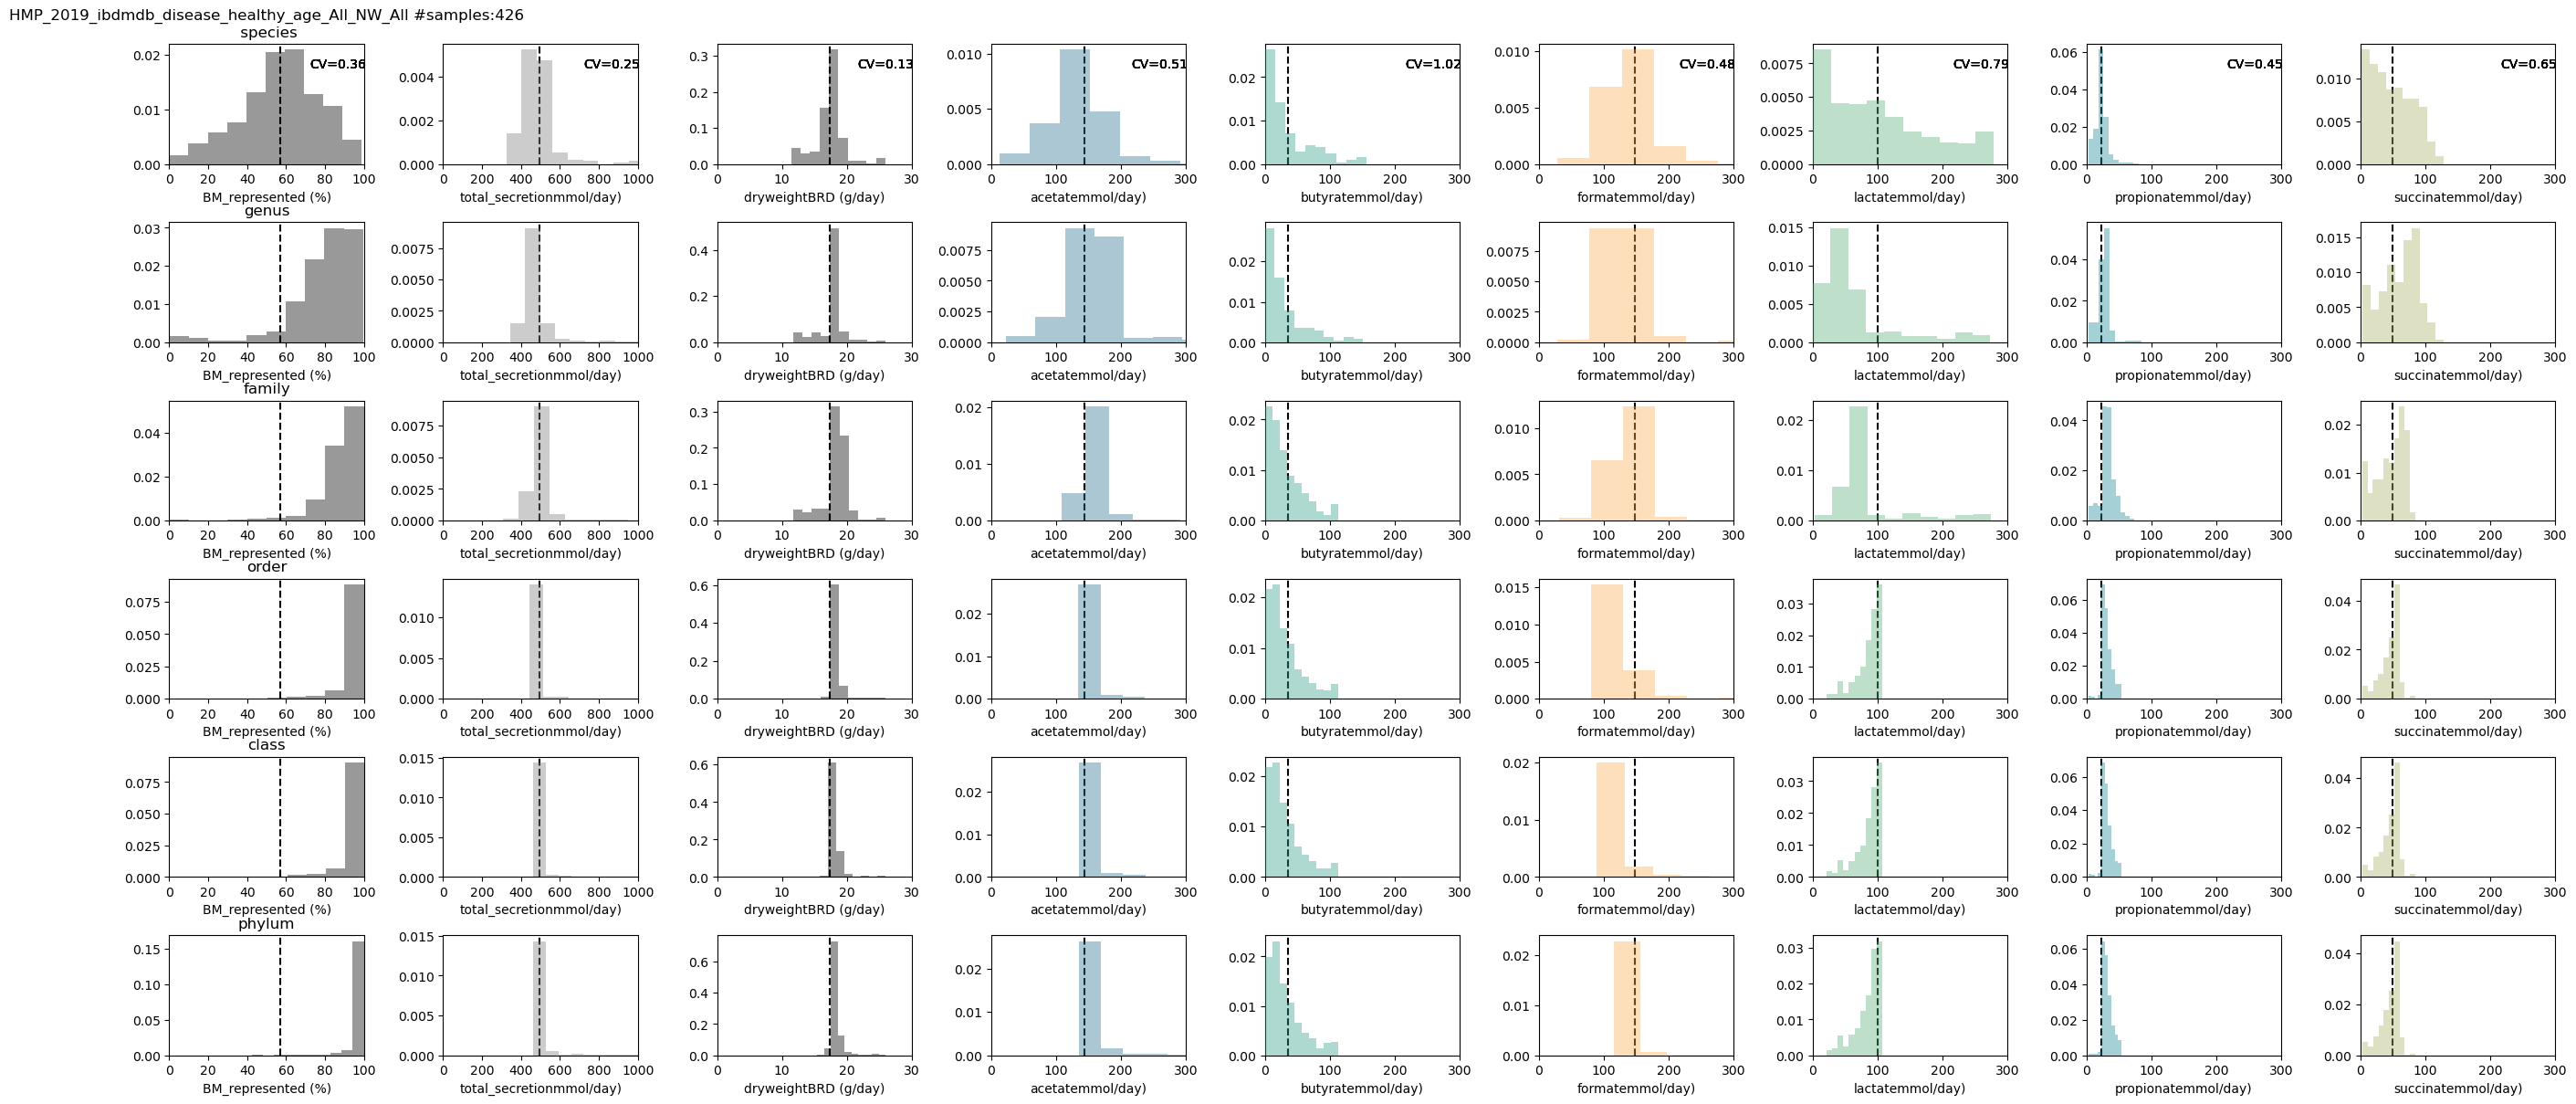

In [19]:
fig, ax=plt.subplots(len(taxlevels),len(quantities_to_plot),figsize=(3*len(quantities_to_plot),2*len(taxlevels))) #first column y, second colum x
iC = 0
condition = name_conditionlist[0]
tL=-1
for taxlevel_select in taxlevels:
    taxlevel_select_index=taxlevels.index(taxlevel_select)
    tL=tL+1
    pQ = -1
    for plot_quantity in quantities_to_plot:
        pQ=pQ+1
        curdata=results_taxlevel[iC][pQ][taxlevels.index("species")]
        curdata_phylalevel=results_taxlevel[iC][pQ][taxlevel_select_index]
        if len(curdata_phylalevel)==0:
            plottaxonomiclevel=False
        else:
            plottaxonomiclevel=True
        
        
        mean=curdata.mean()
        std=curdata.std()
        cv=std/mean
        if pQ==0 and tL==0:
            ax[tL,pQ].set_title(condition+" #samples:"+str(curdata.shape[0])+"\n "+taxlevel_select)
        elif pQ==0:
            ax[tL,pQ].set_title(taxlevel_select)
            
        
        
        ax[tL,pQ].text(0.72,0.8,"CV="+str(round(cv,2)),c='k',transform=ax[iC,pQ].transAxes)

        if plottaxonomiclevel:
            ax[tL,pQ].hist(curdata_phylalevel,color=colorlistcc[pQ],alpha=0.4,density=True,zorder=4)
        
        
        ax[tL,pQ].axvline(mean,ls='--',c='k')
        ax[tL,pQ].set_xlabel(labellist[pQ])
        ax[tL,pQ].set_xlim(0,limmaxlist[pQ])            
    fig.tight_layout()
    fig.savefig("plot_output_figure3/distribution_microbiomesamples"+conditionname+".pdf")

# Compare average excretion for specific dataset with simple mean of all experimentally characterized species

After estimation of microbiota averages excretion values for different studies we compare here the values to a simple average, i.e. assuming all 16 characterized strains are equally abundance.

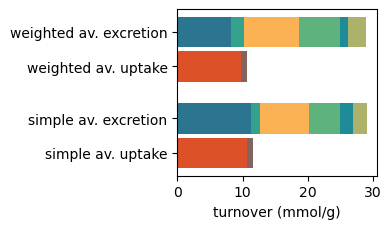

In [9]:

#decide which study to analyze
conditionlist=["selectedsamples_HMP_2019_ibdmdb_disease_healthy_age_All_NW_All"]
f = open (os.path.join("data_analysisresults/average_excretion","av_YCA.json"), "r")
simple_average=json.loads(f.read())
f.close()
 
for condition in conditionlist:
    f = open (os.path.join("data_analysisresults/average_excretion",condition+".json"), "r")
    study_average=json.loads(f.read())
    f.close()

    maxrange_use=[0, 0, 21.91328286546662, 427.97354951182075, 32.53933894024488, 86.44828371059165, 241.13863475930566, 131.90435581431424, 676.3332648399427, 548.4887811755605, 1719.625521469051]

    #to collect data for later
    results_list=[]
    resultsall=[]

    studycountc=-1

    fig,ax=plt.subplots(1,1,figsize=(4,2.4))
    
    ax.set_xlabel("turnover (mmol/g)")
    ax.set_yticks([0.4,0.8,1.4,1.8])
    ax.set_yticklabels(["simple av. uptake","simple av. excretion","weighted av. uptake","weighted av. excretion"])
    utav=0
    utmbav=0
    exav=0
    exmbav=0
    iS=-1
    h=0.35
    for sub in sublist:
        iS=iS+1
        if sub in ["glucose"]:
            ax.barh(0.4,-1*simple_average[sub],left=utav,color=sublist_color[iS],height=h)
            utav=utav-simple_average[sub]
            
            ax.barh(1.4,-1*study_average[sub],left=utmbav,color=sublist_color[iS],height=h)
            utmbav=utmbav-study_average[sub]
        elif sub in ["maltose"]:
            ax.barh(0.4,-2*simple_average[sub],left=utav,color=sublist_color[iS],height=h)
            utav=utav-2*simple_average[sub]
            
            ax.barh(1.4,-1*study_average[sub],left=utmbav,color=sublist_color[iS],height=h)
            utmbav=utmbav-study_average[sub]
            
        else:
            ax.barh(0.8,simple_average[sub],left=exav,color=sublist_color[iS],height=h)
            exav=exav+simple_average[sub]
            
            ax.barh(1.8,study_average[sub],left=exmbav,color=sublist_color[iS],height=h)
            exmbav=exmbav+study_average[sub]
    #ax.set_yticks([1,2])
    #ax.set_yticklabels(["standard","weighted"])
    fig.tight_layout()
    fig.savefig("plot_output_figure3/comparison_average_and_weighted.pdf")